# Imports

In [25]:
import numpy as np                     
import pandas as pd
import random as rand
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt       
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.patches as patches
from matplotlib.lines import Line2D

import braingeneers                  
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster
import braingeneers.data.datasets_electrophysiology as ephys


In [2]:
sd = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')

/tmp/ipykernel_2127/653605344.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')


In [3]:
def calculate_mean_firing_rates(spike_data):
    # Compute mean firing rates for each neuron
    firing_rates = [len(train) / spike_data.length for train in spike_data.train]
    return firing_rates

def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

In [4]:
def precalculate_distances_angles(neuron_positions):
    # Vectorized calculation of distances
    diff = neuron_positions[:, np.newaxis, :] - neuron_positions[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))
    
    # Vectorized calculation of angles
    angles = np.arctan2(diff[..., 1], diff[..., 0]) % (2 * np.pi)
    
    return distances, angles

def calculate_relative_distance_metrics(spike_data, spatial_range, time_window, bins):
    neuron_positions = get_neuron_positions(spike_data)
    distances, _ = precalculate_distances_angles(neuron_positions)
    
    relative_distance_metrics = []

    # Histogram bins for distances
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins + 1)

    for neuron_id, spikes in enumerate(spike_data.train):
        for spike_time in spikes:
            # Identify neurons within the spatial range
            within_range = np.logical_and(distances[neuron_id] >= spatial_range[0], distances[neuron_id] <= spatial_range[1])
            
            neuron_distances = []

            for other_id, other_spikes in enumerate(spike_data.train):
                if neuron_id == other_id or not within_range[other_id]:
                    continue
                
                time_diff = np.abs(other_spikes - spike_time)
                valid_spikes = time_diff <= time_window
                
                if valid_spikes.any():
                    valid_distance = distances[neuron_id, other_id]
                    neuron_distances.append(valid_distance)
            
            if neuron_distances:
                # Collect distances in histograms within the defined bins
                hist, _ = np.histogram(neuron_distances, bins=distance_bins)
                relative_distance_metrics.append((neuron_id, spike_time, hist))
    
    return relative_distance_metrics, distance_bins

def plot_distance_activity(spike_data, spatial_range, grid_size, time_window, bins):
    relative_distance_metrics, distance_bins = calculate_relative_distance_metrics(spike_data, spatial_range, time_window, bins)
    num_cells = int(np.ceil(spatial_range[1] / grid_size))
    
    distance_grid = np.zeros((num_cells, num_cells, bins))  # For distance histograms
    
    neuron_positions = get_neuron_positions(spike_data)
    cell_positions = np.floor(neuron_positions / grid_size).astype(int)
    
    for neuron_id, spike_time, distance_hist in relative_distance_metrics:
        cell_x, cell_y = cell_positions[neuron_id]
        cell_x = min(cell_x, num_cells - 1)
        cell_y = min(cell_y, num_cells - 1)
        distance_grid[cell_y, cell_x] += distance_hist
    
    # Normalize
    norm = np.linalg.norm(distance_grid, axis=2, keepdims=True)
    norm[norm == 0] = 1
    distance_grid /= norm
    
    # Plotting
    plt.figure(figsize=(10, 8))
    for i in range(bins):
        plt.subplot(3, 3, i + 1)
        plt.imshow(distance_grid[:, :, i], extent=[0, spatial_range[1], 0, spatial_range[1]])
        plt.title(f'Distance Bin {distance_bins[i]:.2f}-{distance_bins[i+1]:.2f} μm')
        plt.xlabel('X Position (μm)')
        plt.ylabel('Y Position (μm)')
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2127/2495652857.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


ValueError: num must be an integer with 1 <= num <= 6, not 7

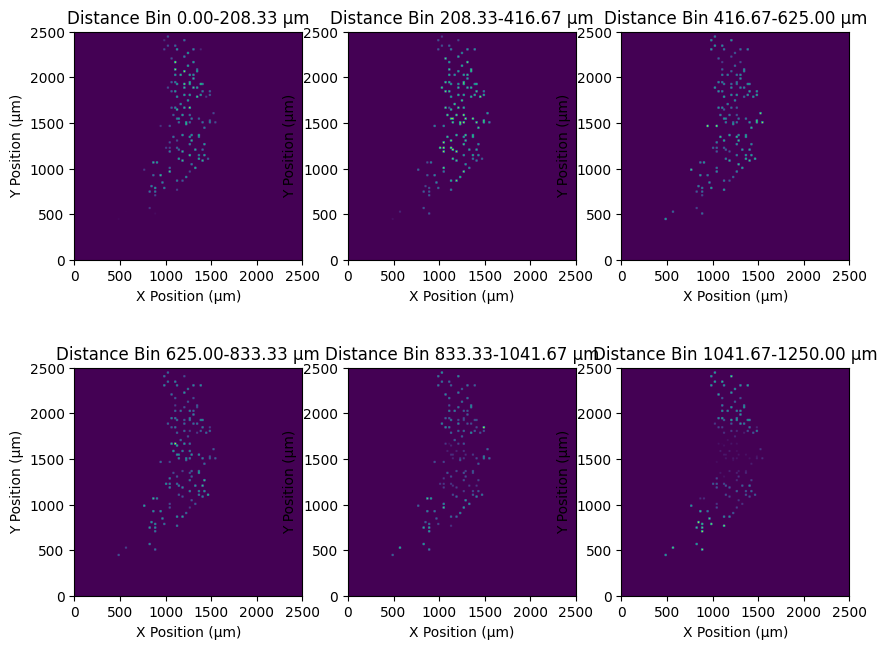

In [6]:
spatial_range = [0, 2500]  # μm
time_window = 20  # Time window for considering coincident spikes
grid_size = 20  # Size
plot_distance_activity(sd, spatial_range, grid_size, time_window, 12)

In [17]:
def plot_distance_activity_single(spike_data, spatial_range, grid_size, time_window, bins):
    relative_distance_metrics, distance_bins = calculate_relative_distance_metrics(spike_data, spatial_range, time_window, bins)
    num_cells = int(np.ceil(spatial_range[1] / grid_size))
    
    # Initialize the grid for spatial averaging
    distance_grid = np.zeros((num_cells, num_cells))
    
    neuron_positions = get_neuron_positions(spike_data)
    cell_positions = np.floor(neuron_positions / grid_size).astype(int)

    # Apply a spatial sliding window and accumulate the distance metrics
    for neuron_id, spike_time, distance_hist in relative_distance_metrics:
        cell_x, cell_y = cell_positions[neuron_id]
        # Ensure indices are within the grid
        cell_x = np.clip(cell_x, 0, num_cells - 1)
        cell_y = np.clip(cell_y, 0, num_cells - 1)
        distance_grid[cell_y, cell_x] += np.mean(distance_hist)  # Average distance for this event

    # Subtract local structure using a larger sliding window
    from scipy.ndimage import uniform_filter
    large_window_size = int(336 / grid_size)  # Convert 336μm to grid cells
    local_structure = uniform_filter(distance_grid, size=large_window_size)
    distance_grid -= local_structure

    # Normalize by standard deviation
    std_dev = np.std(distance_grid)
    normalized_distance_grid = distance_grid / std_dev

    # Plot the heatmap
    plt.figure(figsize=(8, 8))  # Adjust figure size to be square as well
    ax = plt.gca()
    im = ax.imshow(normalized_distance_grid, cmap='viridis', extent=[spatial_range[0], spatial_range[1], 0, spatial_range[1]])
    
    # Set aspect of the plot to 'equal' to ensure squares are displayed as square
    ax.set_aspect('equal')
    
    # Add a colorbar with label
    plt.colorbar(im, label='Average Distance (normalized)')
    
    # Add titles and labels
    plt.title('Spatial Activity Patterns - Distance Bias')
    plt.xlabel('X Position (μm)')
    plt.ylabel('Y Position (μm)')
    
    # Show the plot
    plt.show()

/tmp/ipykernel_2127/2495652857.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


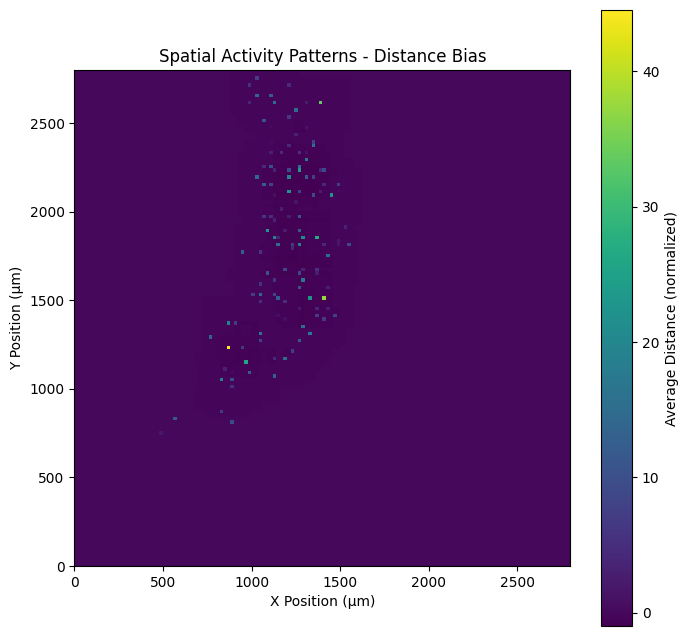

In [16]:
spatial_range = [0, 2800]  # μm
time_window = 20  # Time window for considering coincident spikes
grid_size = 20  # Size
bins = 12  # Number of distance bins
plot_distance_activity_single(sd, spatial_range, grid_size, time_window, bins)

/tmp/ipykernel_2127/2495652857.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


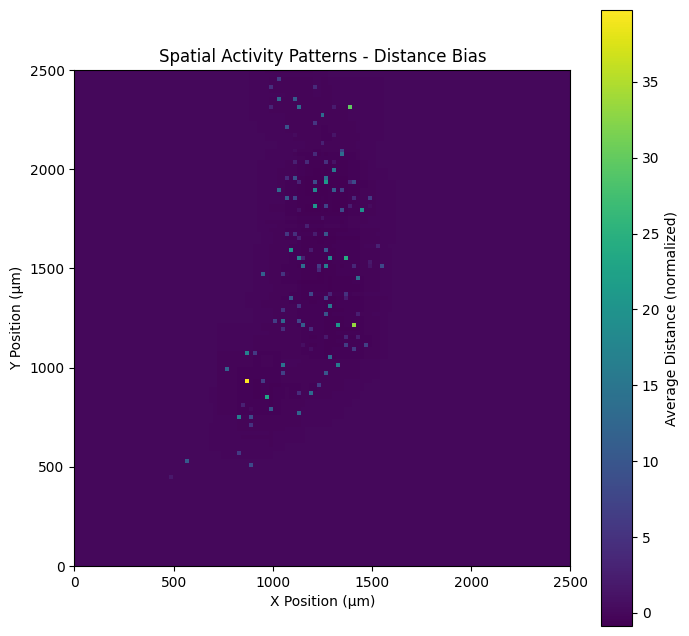

In [18]:
spatial_range = [0, 2500]  # μm
time_window = 20  # Time window for considering coincident spikes
grid_size = 20  # Size
bins = 12  # Number of distance bins
plot_distance_activity_single(sd, spatial_range, grid_size, time_window, bins)

In [29]:
def plot_distance_activity_single2(spike_data, spatial_range, grid_size, time_window, bins):
    relative_distance_metrics, distance_bins = calculate_relative_distance_metrics(spike_data, spatial_range, time_window, bins)
    num_cells = int(np.ceil(spatial_range[1] / grid_size))
    
    # Initialize the grid for spatial averaging
    distance_grid = np.zeros((num_cells, num_cells))
    
    neuron_positions = get_neuron_positions(spike_data)
    cell_positions = np.floor(neuron_positions / grid_size).astype(int)

    # Apply a spatial sliding window and accumulate the distance metrics
    for neuron_id, spike_time, distance_hist in relative_distance_metrics:
        cell_x, cell_y = cell_positions[neuron_id]
        # Ensure indices are within the grid
        cell_x = np.clip(cell_x, 0, num_cells - 1)
        cell_y = np.clip(cell_y, 0, num_cells - 1)
        distance_grid[cell_y, cell_x] += np.mean(distance_hist)  # Average distance for this event

    # Subtract local structure using a larger sliding window
    from scipy.ndimage import uniform_filter
    large_window_size = int(336 / grid_size)  # Convert 336μm to grid cells
    local_structure = uniform_filter(distance_grid, size=large_window_size)
    distance_grid -= local_structure

    # Calculate the mean and standard deviation of the distance grid
    mean_value = np.mean(distance_grid)
    std_dev = np.std(distance_grid)
    
    # Create a normalization that scales from -3 to +3 standard deviations
    norm = Normalize(vmin=-3, vmax=3)

    # Create a colormap that is grey in the middle and diverges to colors
    cmap = plt.cm.coolwarm
    cmap.set_bad('grey', 1.0)  # Set the color for NaN values

    # Set the background of the plot to grey
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_facecolor('grey')

    # Normalize the distance grid to standard deviations
    normalized_grid = (distance_grid - mean_value) / std_dev

    # Apply the normalization and colormap to the data
    im = ax.imshow(normalized_grid, cmap=cmap, norm=norm, extent=[0, spatial_range[1]/1000, 0, spatial_range[1]/1000])

    # Set aspect to equal for a square grid
    ax.set_aspect('equal')

    # Add a colorbar with label for average distance per millimeter
    colorbar = plt.colorbar(im)
    colorbar.set_label('Average Distance (mm)')

    # Add titles and labels
    plt.title('Spatial Activity Patterns - Distance Bias')
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')

    # Show the plot
    plt.show()

/tmp/ipykernel_2127/2495652857.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


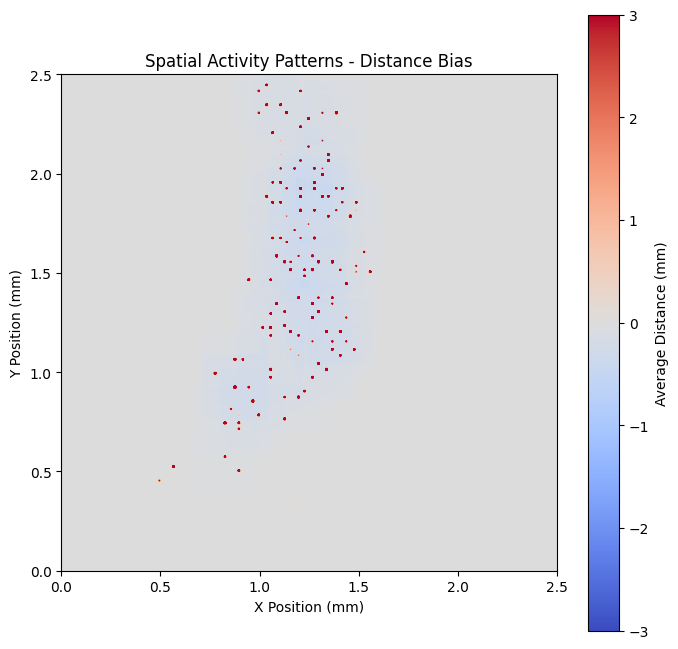

In [31]:
spatial_range = [0, 2500]  # μm
time_window = 20  # Time window for considering coincident spikes
grid_size = 10  # Size
bins = 12  # Number of distance bins
plot_distance_activity_single2(sd, spatial_range, grid_size, time_window, bins)